**Team Members:**
**Gowtham Arulmozhi, Suriyakrishnan Sathish and Jan Bucher.**

**Team Name: GASJBS**

# AI534 Implementation Assignment 2###

**Deadline**: Sunday, Oct. 29, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

In this assignment, we will implement and experiment with logistic regression with L2 and L1 regularization to predict whether a health insurance customer will purchase car insurance as well based on a set of features.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that your TA can understand what you are doing and why.

First lets import the necessary packages.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Loading data and perform feature normalization for numerical features

---

On canvas, we have provided three different data files for this assignment: IA2-train.csv (for training), IA2-dev.csv(for validation) and IA2-train-noisy.csv (for noisy training). Download them and upload them to your google drive. Then mount the google drive from your google colab notebook:


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/IA2-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/IA2-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
noisy_train_path = '/content/gdrive/My Drive/AI534/IA2-train-noisy.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


You have one additional preprocessing step to do, which is to perform feature normalization (z-score) for 3 numerical features ("Age", "Annual_Premium", "Vintage").

In [ ]:

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_noisy_train = pd.read_csv(noisy_train_path)

In [ ]:
df_noisy_train

,dummy,Gender,Age,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Region_Code_0,Region_Code_1,...,Policy_Sales_Channel_153,Policy_Sales_Channel_154,Policy_Sales_Channel_155,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_158,Policy_Sales_Channel_159,Policy_Sales_Channel_160,Policy_Sales_Channel_163,Response
0,1,1,24,1,0,1,2630,187,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,0,44,1,0,1,56865,150,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,32,1,0,1,50126,188,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,56,1,0,1,45578,89,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,32,1,0,1,2630,227,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,0,41,1,0,0,34796,96,0,0,...,0,0,0,0,0,0,0,0,0,0
5996,1,1,35,1,0,1,25667,53,0,0,...,0,0,0,0,0,0,0,0,0,1
5997,1,0,37,1,0,1,2630,183,0,0,...,0,0,0,0,0,0,0,1,0,0
5998,1,0,37,1,0,1,27226,138,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train.shape, df_val.shape, df_noisy_train.shape

((6000, 198), (10000, 198), (6000, 198))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 198 entries, dummy to Response
dtypes: int64(198)
memory usage: 9.1 MB


In [ ]:
df_train_norm = df_train.copy()
df_val_norm = df_val.copy()
df_noisy_train_norm = df_noisy_train.copy()

columns_to_normalize = ["Age", "Annual_Premium", "Vintage"]

# Step 3: Define a function to calculate z-scores.
def calculate_zscore(X, mean, std_dev):
    zscores = (X - mean) / std_dev
    return zscores

# Step 4: Calculate mean and standard deviation for each column to be normalized and call the function to calculate the z-score for train, val, noisy_train
for col in columns_to_normalize:
    mean = df_train[col].mean()
    std_dev = df_train[col].std()
    print(f'Mean {col} : {mean}')
    print(f'Std {col} : {std_dev}')
    df_train_norm[col] = calculate_zscore(df_train[col], mean, std_dev)
    df_val_norm[col] = calculate_zscore(df_val[col], mean, std_dev)
    df_noisy_train_norm[col] = calculate_zscore(df_noisy_train[col], mean, std_dev)

Mean Age : 40.569833333333335
Std Age : 14.139912051507238
Mean Annual_Premium : 30773.049833333334
Std Annual_Premium : 17532.770733380436
Mean Vintage : 155.04166666666666
Std Vintage : 83.64117948139976


In [ ]:
df_train_norm[columns_to_normalize]

,Age,Annual_Premium,Vintage
0,-1.171848,-1.605168,0.382089
1,0.242588,1.488182,-0.060277
2,-0.606074,1.103816,0.394044
3,1.091249,0.844416,-0.789583
4,-0.606074,-1.605168,0.860322
...,...,...,...
5995,0.030422,0.229453,-0.705892
5996,-0.393909,-0.291229,-1.219993
5997,-0.252465,-1.605168,0.334265
5998,-0.252465,-0.202310,-0.203747


In [ ]:
df_val_norm.shape

(10000, 198)

# Part 1 (35 pts) Logstic regression with L2 (Ridge) regularization

For this part of the assignment, you will implement and experiment with Logistic regression with L2 regularization (Algorithm 1 in Assignment 2 Reference Information).


## Impelement Logistic regression with L2 regularization

> Indented block


As a recommendation, your implemented function should consider the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threhold of $10^{-7}$. )

Your function should output the learned weight vector. But it is also a good idea to output the sequence of losses so that you can visualize the convergence process to ensure proper convergence. You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.



In [ ]:
class RidgeLogisticRegressionWithL2():
    def __init__(self, learning_rate=0.01, epochs=5000, l2_penalty=1e-1, convergence_threshold=1e-7):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.l2_penalty = l2_penalty
        self.convergence_threshold = convergence_threshold

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        prev_loss = float('inf')
        logistic_loss = []

        for i in range(self.epochs):
            z = np.dot(X, self.weights)
            y_hat = self.sigmoid(z)
            gradient = (1 / len(X)) * np.dot(X.T, (y_hat - y))
            gradient[1:] += self.l2_penalty * self.weights[1:]

            self.weights -= self.learning_rate * gradient

            loss = (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean() + (self.l2_penalty / 2) * np.dot(self.weights, self.weights)
            logistic_loss.append(loss)

            if abs(prev_loss - loss) < self.convergence_threshold:
                print(f"Converged after {i} iterations.")
                break
            prev_loss = loss

        return logistic_loss, self.weights

    def predict(self, X):
        z = np.dot(X, self.weights)
        return z


##Experiment with different regularization parameters
For this part, you will need to run your L2 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-5, 0]\}$. This is the minimim range of values required. Feel free to experiment with more extreme or in-between values to help you answer the questions.

**Learning Rate Tuning Guidelines:**
For different values of $\lambda$, you'll need varying learning rates. I recommend starting with $\gamma = 1$ for very small $\lambda$s like $10^{-5}, 10^{-4}$. For larger $\lambda$ values like $10^{-3}$, consider a smaller learning rate like $\gamma = 0.1$. You will need to further reduce the learning rate as $\lambda$ gets bigger.

For each $\lambda$ value, you are required to run the logistic regression to convergence, record the resulting model (the weight vector), evaluate it on the training and validation data and record the accuracies.

In [ ]:
df_train_norm

,dummy,Gender,Age,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Region_Code_0,Region_Code_1,...,Policy_Sales_Channel_153,Policy_Sales_Channel_154,Policy_Sales_Channel_155,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_158,Policy_Sales_Channel_159,Policy_Sales_Channel_160,Policy_Sales_Channel_163,Response
0,1,1,-1.171848,1,0,1,-1.605168,0.382089,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,0,0.242588,1,0,1,1.488182,-0.060277,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,-0.606074,1,0,1,1.103816,0.394044,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1.091249,1,0,1,0.844416,-0.789583,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,-0.606074,1,0,1,-1.605168,0.860322,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,0,0.030422,1,0,0,0.229453,-0.705892,0,0,...,0,0,0,0,0,0,0,0,0,0
5996,1,1,-0.393909,1,0,1,-0.291229,-1.219993,0,0,...,0,0,0,0,0,0,0,0,0,1
5997,1,0,-0.252465,1,0,1,-1.605168,0.334265,0,0,...,0,0,0,0,0,0,0,1,0,1
5998,1,0,-0.252465,1,0,1,-0.202310,-0.203747,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
# display(df_train_norm.isnull().sum())

In [ ]:
X_train = df_train_norm.drop(columns=['Response'])
X_val = df_val_norm.drop(columns=['Response'])

feature_names = X_train.columns.tolist()


X_train = np.array(X_train)
X_val = np.array(X_val)


y_train = df_train_norm.Response
y_val = df_val_norm.Response

In [ ]:
def calculate_accuracy(X, Y, weights):
    # Calculate the predicted probabilities
    predicted_probabilities = 1 / (1 + np.exp(-np.dot(X, weights)))

    # Convert probabilities to binary predictions (0 or 1)
    predicted_labels = (predicted_probabilities >= 0.5).astype(int)

    # Calculate accuracy by comparing predicted labels to true labels
    accuracy = np.mean(predicted_labels == Y)

    return accuracy


In [ ]:
X_train

array([[ 1.        ,  1.        , -1.1718484 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.24258755, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        , -0.60607402, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.        ,  0.        , -0.25246503, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        ,  0.        , -0.25246503, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.        ,  1.8691889 , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# Define a range of regularization parameters 𝜆
lambda_values = [10 ** i for i in range(-5, 1)]
print(f'lambda Values : {lambda_values}')

# Initialize a dictionary to store the results
results_list = []
sparsity_results = {}
top_features_lambda = {}
top_features_df = {}# Sort features by magnitude of weight (excluding the bias term)

# Loop over each 𝜆 value
for lambda_reg in lambda_values:
    # Set learning rate based on 𝜆 value
    if lambda_reg <= 1e-4:
        learning_rate = 1.0
    else:
        learning_rate = 0.1

    # Create an instance of the RidgeRegressorwithGD class
    model = RidgeLogisticRegressionWithL2(l2_penalty=lambda_reg, learning_rate=learning_rate)

    # Fit the model to convergence using your training data
    logistic_loss, learned_weights = model.fit(X_train, y_train)



    #Predicting the values
    z_pred = model.predict(X_val)

    y_pred = model.sigmoid(z_pred)

    # Sort feature indices by magnitude of weight (excluding the bias term)
    feature_indices = np.argsort(np.abs(learned_weights[1:]))[::-1][:5]

    # Create a list of top features with their names and weights
    top_features_lambda = [(f'Feature {index}', round(learned_weights[index], 4)) for index in feature_indices]

    # Store the top features in the DataFrame
    top_features_df[lambda_reg] = top_features_lambda

    # Compute sparsity by counting the number of feature weights close to zero
    sparsity = np.sum(np.abs(learned_weights) <= 1e-6)

    # Store the sparsity result for this λ value
    sparsity_results[lambda_reg] = sparsity

    # Evaluate the model on the training data
    train_accuracy = calculate_accuracy(X_train, y_train, learned_weights)

    # Evaluate the model on the validation data
    val_accuracy = calculate_accuracy(X_val, y_val, learned_weights)

    # Store the results for this 𝜆 value
    result_dict = {
        'λ': lambda_reg,
        'weights': learned_weights,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'logistic_loss': logistic_loss,
        'top_features': top_features_lambda,
        'sparsity': sparsity
    }
    results_list.append(result_dict)

results_df = pd.DataFrame(results_list)
results_df.set_index('λ', inplace=True)

# Add 'λ' as a regular column
results_df.reset_index(inplace=True)
results_df

lambda Values : [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
Converged after 4502 iterations.
Converged after 980 iterations.
Converged after 169 iterations.
Converged after 520 iterations.


,λ,weights,train_accuracy,val_accuracy,logistic_loss,top_features,sparsity
0,0.00001,"[-1.5536967668817, 0.046034795583173777, -0.40...",0.801167,0.7923,"[0.6931475011981081, 0.6381059195872574, 0.605...","[(Feature 3, 0.5336), (Feature 4, -3.2767), (F...",47
1,0.00010,"[-1.572194122293521, 0.04499117662124044, -0.3...",0.801167,0.7928,"[0.6931503869415722, 0.6381145605551128, 0.605...","[(Feature 3, 0.4307), (Feature 4, -3.1697), (F...",47
2,0.00100,"[-0.8788979790800092, 0.03722171820289536, -0....",0.797167,0.7936,"[0.6931475011981081, 0.6868269598214409, 0.680...","[(Feature 3, -0.337), (Feature 4, -2.5717), (F...",47
3,0.01000,"[-0.5407969680376319, 0.01704660929423435, -0....",0.786000,0.7854,"[0.6931503869415722, 0.68683816524073, 0.68088...","[(Feature 3, -0.2518), (Feature 4, -1.5825), (...",47
4,0.10000,"[-0.1963698789570652, 0.013282292110172891, 0....",0.778833,0.7809,"[0.6931792443762128, 0.6869490965926669, 0.681...","[(Feature 3, -0.0788), (Feature 4, -0.6112), (...",47
5,1.00000,"[-0.10313033406216324, 0.014441643108730572, 0...",0.746833,0.7474,"[0.6934678187226199, 0.6879489790765222, 0.683...","[(Feature 4, -0.1124), (Feature 3, 0.0003), (F...",48


### 1.1 Impact on training and validation accuracy

Plot the training accuracy and validation accuracy of the learned L2 regularized logistic regression model as a function of $\lambda$.
When plotting, use a logarithmic scale for the x-axis to represent $\lambda$. In other words, each tick mark on the x-axis should correspond to a unique integar $i$ and be labeled as $10^{-i}$. This will allow us to better visualize how the model performance changes across different orders of magnitude for $\lambda$.  

Please plot the two curves in the same figure using different colors for easy comparison. Provide clear legend to indicate which curve is which.

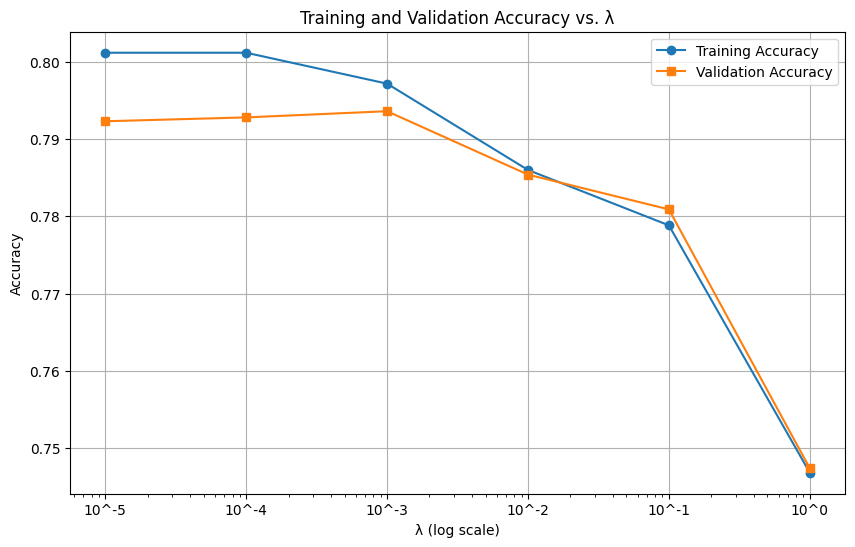

In [ ]:
# Plot the training accuracy and validation accuracy on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.semilogx(results_df['λ'], results_df['train_accuracy'], label='Training Accuracy', marker='o')
plt.semilogx(results_df['λ'], results_df['val_accuracy'], label='Validation Accuracy', marker='s')

plt.xlabel('λ (log scale)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. λ')
plt.legend()
plt.grid(True)

# Set x-axis ticks to represent λ as 10^-i
plt.xticks(lambda_values, ['10^{}'.format(int(np.log10(lambda_value))) for lambda_value in lambda_values])

plt.show()


**Question**

(a) Which $\lambda$ value leads to the best training and validation accuracy respectively? Which one should you use if you are to pick a model for deployment?

(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.


**Answer:**

**(a)** *To determine which λ value leads to the best training and validation accuracy and which one to use for deployment, you should choose the λ value that results in the highest validation accuracy. In your case, λ = 0.001 leads to the highest validation accuracy of 0.7936. Therefore, λ = 0.001 should be used if you are to pick a model for deployment.*

**(b)** The trend for the training and validation accuracy as you increase λ is as follows:

As λ increases, both training and validation accuracy decrease.
Training accuracy decreases at a faster rate compared to validation accuracy as λ increases.
The explanation for this trend is that λ is the regularization parameter (typically called "lambda" in the context of L2 regularization, which is commonly used with methods like linear regression or logistic regression). Regularization helps prevent overfitting by adding a penalty term to the loss function, encouraging the model to have smaller weight values. As you increase λ, the penalty for large weight values becomes more significant, causing the model to reduce the magnitude of its weights.

This reduction in weight magnitudes results in a simpler model, which is less prone to overfitting. However, too much regularization (very large λ) can lead to underfitting, where the model is too simple and can't capture the underlying patterns in the data. This is why training accuracy decreases as λ increases.

The fact that validation accuracy is still relatively high for λ = 0.001 suggests that it's finding a good balance between regularization and fitting the data.λ = 0.001 has the best compromise between preventing overfitting and fitting the data well, making it the most suitable choice for deployment. *italicized text*

###1.2 Impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

The easiest way is to create a dataframe for this table and print the dataframe.

In [ ]:
# Assuming you have results_df already created and contains your results

# Create a dictionary to store top 5 feature indices for each λ value
top_feature_indices_dict = {}

# Loop over each λ value and extract the top 5 feature indices
for lambda_reg, row in results_df.iterrows():
    top_features = row['top_features']
    top_feature_indices = [(f'Feature_{int(feature.split()[-1])}', round(weights,4)) for feature, weights in top_features]
    top_feature_indices_dict[lambda_reg] = top_feature_indices

print(top_feature_indices_dict)

lambdaa = ['λ_1e-5','λ_1e-4','λ_1e-3','λ_1e-2','λ_1e-1','λ_1e-0']

# Convert the dictionary into a DataFrame
top_feature_indices_df = pd.DataFrame.from_dict(top_feature_indices_dict)
top_feature_indices_df.columns = lambdaa
top_feature_indices_df.insert(0, 'Rank', range(1, len(top_feature_indices_df) + 1))

# Print the resulting DataFrame
top_feature_indices_df = top_feature_indices_df.reset_index(drop=True)
top_feature_indices_df


{0: [('Feature_3', 0.5336), ('Feature_4', -3.2767), ('Feature_194', 0.0), ('Feature_76', -0.4694), ('Feature_41', -0.3884)], 1: [('Feature_3', 0.4307), ('Feature_4', -3.1697), ('Feature_194', 0.0), ('Feature_76', -0.3917), ('Feature_41', -0.362)], 2: [('Feature_3', -0.337), ('Feature_4', -2.5717), ('Feature_194', 0.0), ('Feature_186', -0.1201), ('Feature_61', -0.112)], 3: [('Feature_3', -0.2518), ('Feature_4', -1.5825), ('Feature_186', -0.0348), ('Feature_61', 0.0451), ('Feature_194', 0.0)], 4: [('Feature_3', -0.0788), ('Feature_4', -0.6112), ('Feature_186', -0.0093), ('Feature_61', 0.0995), ('Feature_86', 0.0044)], 5: [('Feature_4', -0.1124), ('Feature_3', 0.0003), ('Feature_61', 0.0459), ('Feature_186', -0.0017), ('Feature_1', 0.0144)]}


,Rank,λ_1e-5,λ_1e-4,λ_1e-3,λ_1e-2,λ_1e-1,λ_1e-0
0,1,"(Feature_3, 0.5336)","(Feature_3, 0.4307)","(Feature_3, -0.337)","(Feature_3, -0.2518)","(Feature_3, -0.0788)","(Feature_4, -0.1124)"
1,2,"(Feature_4, -3.2767)","(Feature_4, -3.1697)","(Feature_4, -2.5717)","(Feature_4, -1.5825)","(Feature_4, -0.6112)","(Feature_3, 0.0003)"
2,3,"(Feature_194, 0.0)","(Feature_194, 0.0)","(Feature_194, 0.0)","(Feature_186, -0.0348)","(Feature_186, -0.0093)","(Feature_61, 0.0459)"
3,4,"(Feature_76, -0.4694)","(Feature_76, -0.3917)","(Feature_186, -0.1201)","(Feature_61, 0.0451)","(Feature_61, 0.0995)","(Feature_186, -0.0017)"
4,5,"(Feature_41, -0.3884)","(Feature_41, -0.362)","(Feature_61, -0.112)","(Feature_194, 0.0)","(Feature_86, 0.0044)","(Feature_1, 0.0144)"


**Question**

1.Do you observe any difference is the top features with different  𝜆  values?

2.Do you observe any difference in the weights of the top features for different  𝜆  values?


3.Please provide your own explanation/interpretation of the observed differences."

**Answer:**

**(1)** *There are noticeable differences in the top features when examining various λ values. For instance, as λ varies, different features take precedence in terms of importance. For instance, at λ=1e-5, Feature_3 holds the top position with a weight of 0.5336, but at λ=1e-4, Feature_4 assumes the lead with a much larger negative weight of -3.2767. These shifts in top features signify that the regularization strength plays a substantial role in feature selection, affecting which features are considered most relevant for the model.*

**(2)** *The weights assigned to the top features vary significantly with changes in λ. In the case of λ=1e-5, Feature_3 carries a weight of 0.5336, but as λ increases to 1e-4, Feature_4 takes precedence with a much more negative weight of -3.2767. This change in weights reflects the influence of regularization. Smaller λ values, as seen in the first case, allow for more significant feature weights, while larger λ values, as in the second case, impose penalties on feature weights, reducing their magnitude.*

**(3)** *The observed differences in top features and their weights for varying λ values can be explained in the context of regularization. Regularization is a technique used in machine learning to prevent overfitting by introducing penalties on feature weights. Smaller λ values (e.g., λ=1e-5) give less importance to regularization, permitting certain features to have larger, potentially positive, weights. Conversely, larger λ values (e.g., λ=1e-4) emphasize the regularization term more, thus discouraging large feature weights. This change in top features and weights reflects a trade-off between the complexity of the model and its predictive accuracy. Smaller λ values might lead to more complex models, while larger λ values simplify them by de-emphasizing certain features. Selecting the appropriate λ value should be guided by the specific problem and the balance between model complexity and accuracy, often determined through cross-validation.*

###1.3 sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [ ]:
# Create a DataFrame from the sparsity results dictionary
sparsity_df = pd.DataFrame.from_dict(sparsity_results, orient='index', columns=['Sparsity'])

# Name the index column
sparsity_df.index.name = 'λ'

# Print or use the sparsity DataFrame as needed
sparsity_df

,Sparsity
λ,
0.00001,47
0.00010,47
0.00100,47
0.01000,47
0.10000,47
1.00000,48


**Question**

1. When we have very small $\lambda$ values, does your learned model have zero weights for some features?  If so, why would it be that way?
2. What trend do you observe for the sparsity of the model as we increase $\lambda$? If we further increase $\lambda$ to even larger values, what do you expect to happen to the sparsity value? Why?


**Answer:**

**(1)** No, the learned model does not have zero weights for any features when using very small λ values. This is because in ridge (L2) regularization, the regularization term encourages feature weights to be small but not exactly zero. Ridge regularization is primarily used to prevent overfitting and reduce the impact of multicollinearity among features. It does not enforce feature selection in the same way as Lasso (L1) regularization, which can lead to exact zero weights for some features.

**(2)** The trend for the sparsity of the model as we increase λ is a gradual increase in sparsity. As λ increases, the sparsity value increases slightly, indicating that more feature weights become closer to zero but not exactly zero. This is because higher λ values impose a stronger penalty on feature weights, encouraging them to be smaller.

If we further increase λ to even larger values, we would expect the sparsity value to continue to increase. However, it's important to note that there is a trade-off. As λ becomes very large, the model may become too simple, and the training accuracy may start to degrade significantly. You would reach a point where the model becomes underfit, and both training and validation accuracy may drop. The exact point at which this occurs depends on the specific dataset and the interplay between the regularization strength (λ) and the dataset's complexity. In general, very large λ values will push more feature weights toward zero, leading to increased sparsity, but it may also lead to a less effective model.

# Part 2. (40 pts) Logistic regression with L1 regularization.

In this part, we will repeat the part 1 but with L1 regularization. Please refer to the algorithm 2 in the Assignment 2 Reference Information file for the details of the algorithm.

## Impelement Logistic regression with L1 regularization
As a recommendation, your implemented function should consider the following inputs:
1. The training data
2. The regularization parameter $\lambda$
3. The learning rate
4. Max iterations (recommend to start with 5000)
5. Threshold for change in loss (this will be used for early stopping: if the change in loss is less than the threshold, it is considered to have converged. Please use a threshold of $10^{-7}$. )

Your function should output the learned weight vector. But it is also a good idea to output the sequence of losses so that you can visualize the convergence process.
You should also implement a divergence detection, if the loss starts to diverge, terminate and raise an alarm.


In [ ]:
import numpy as np

class LassoLogisticRegressionWithGD():
    def __init__(self, learning_rate=0.01, epochs=5000, l1_penalty=1e-1, convergence_threshold=1e-7):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.l1_penalty = l1_penalty
        self.convergence_threshold = convergence_threshold

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        prev_loss = float('inf')
        logistic_loss = []

        for i in range(self.epochs):
            z = np.dot(X, self.weights)
            y_hat = self.sigmoid(z)

            gradient = (1 / len(X)) * np.dot(X.T, (y_hat - y))
            gradient[1:] += self.l1_penalty * np.sign(self.weights[1:])  # Exclude regularization for the bias term (index 0)
            self.weights -= self.learning_rate * gradient

            # Calculate the loss and check for convergence
            loss = (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean() + self.l1_penalty * np.sum(np.abs(self.weights))
            logistic_loss.append(loss)
            if abs(prev_loss - loss) < self.convergence_threshold:
                print(f"Converged after {i} iterations.")
                break
            prev_loss = loss
        return logistic_loss, self.weights

    def predict(self, X, threshold=0.5):
        z = np.dot(X, self.weights)
        probabilities = self.sigmoid(z)
        return [1 if p >= threshold else 0 for p in probabilities]


##Experiment with different regularization parameters
For this part, you will need to run your L1 logistic regression algorithm on the training data with different regularization parameters $\lambda\in \{10^i: i\in[-6, -1]\}$. You are welcome to experiment with more extreme or in-between values to help you answer the questions. But be advised using larger $\lambda$ values in this case makes it difficult to converge.

**Learning Rate Tuning Guidelines:**
For L1 regularization, I recommend starting with $\gamma = 2$ for very small $\lambda$s like $10^{-6}, 10^{-5}$, and decreasing the learning for larger $\lambda$ values.

For each $\lambda$ value, you are required to run L1 logistic regression to convergence, record the resulting model (weights), evaluate it on the training and validation data, and record the accuracies.

In [ ]:
# Define a range of regularization parameters 𝜆
lambda_values = [10 ** i for i in range(-6, -1)]
print(f'lambda Values : {lambda_values}')

# Initialize a dictionary to store the results
results_list = []
sparsity_results = {}
top_features_lambda = {}
top_features_df = {}# Sort features by magnitude of weight (excluding the bias term)

# Loop over each 𝜆 value
for lambda_reg in lambda_values:

    # Create an instance of the RidgeRegressorwithGD class
    model = LassoLogisticRegressionWithGD(l1_penalty=lambda_reg, learning_rate=2.0)  # Adjust learning rate as needed

    # Fit the model to convergence using your training data
    logistic_loss, learned_weights = model.fit(X_train, y_train)


    # Sort feature indices by magnitude of weight (excluding the bias term)
    feature_indices = np.argsort(np.abs(learned_weights[1:]))[::-1][:5]

    # Create a list of top features with their names and weights
    top_features_lambda = [(f'Feature {index}', round(learned_weights[index], 4)) for index in feature_indices]

    # Store the top features in the DataFrame
    top_features_df[lambda_reg] = top_features_lambda

    # Compute sparsity by counting the number of feature weights close to zero
    sparsity = np.sum(np.abs(learned_weights) <= 1e-6)

    # Store the sparsity result for this λ value
    sparsity_results[lambda_reg] = sparsity

    # Evaluate the model on the training data
    train_accuracy = calculate_accuracy(X_train, y_train, learned_weights)

    # Evaluate the model on the validation data
    val_accuracy = calculate_accuracy(X_val, y_val, learned_weights)

    # Store the results for this 𝜆 value
    result_dict = {
        'λ': lambda_reg,
        'weights': learned_weights,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'logistic_loss': logistic_loss,
        'top_features': top_features_lambda,
        'sparsity': sparsity
    }
    results_list.append(result_dict)

results_df = pd.DataFrame(results_list)
results_df.set_index('λ', inplace=True)

# Add 'λ' as a regular column
results_df.reset_index(inplace=True)
results_df

lambda Values : [1e-06, 1e-05, 0.0001, 0.001, 0.01]
Converged after 1345 iterations.
Converged after 955 iterations.


,λ,weights,train_accuracy,val_accuracy,logistic_loss,top_features,sparsity
0,0.000001,"[-1.8010758942347507, 0.050376662090109416, -0...",0.802333,0.7911,"[0.6931489224441407, 0.6007202891558088, 0.562...","[(Feature 3, 0.8406), (Feature 4, -3.2846), (F...",49
1,0.000010,"[-1.8344674350234407, 0.049843755230727746, -0...",0.801833,0.7915,"[0.6931645994018991, 0.6007439511797608, 0.562...","[(Feature 3, 0.8142), (Feature 4, -3.2799), (F...",48
2,0.000100,"[-1.3641777266599018, 0.038977130808860894, -0...",0.800000,0.7934,"[0.6933213689794822, 0.6009783520843097, 0.562...","[(Feature 3, 0.1461), (Feature 4, -3.2454), (F...",48
3,0.001000,"[-1.3405681380026495, 0.0216044292525134, -0.3...",0.792333,0.7909,"[0.6948890647553124, 0.6032864523732581, 0.566...","[(Feature 3, 0.0008), (Feature 4, -2.9464), (F...",47
4,0.010000,"[-1.0852407571281704, -0.020066639658190437, -...",0.782500,0.7848,"[0.710566022513616, 0.6415153408062702, 0.5997...","[(Feature 3, -0.0126), (Feature 4, -1.9068), (...",47


### 2.1 Impact on training and validation accuracy
Plot the training accuracy and validation accuracy of the learned L1 regularized logistic regression model as a function of $\lambda$. When plotting, use a logarithmic scale for the x-axis to represent $\lambda$. In other words, each tick mark on the x-axis should correspond to a unique integar $i$ and be labeled as  $10^{−i}$ . This will allow us to better visualize how the model performance changes across different orders of magnitude for $\lambda$.

Please plot the two curves in the same figure using different colors for easy comparison. Provide clear legend to indicate which curve is which.

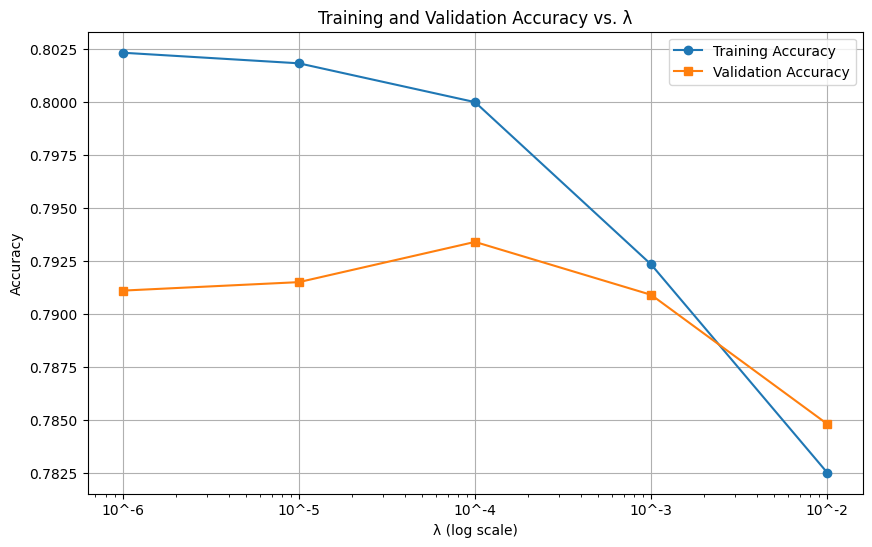

In [ ]:
# Plot the training accuracy and validation accuracy on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.semilogx(results_df['λ'], results_df['train_accuracy'], label='Training Accuracy', marker='o')
plt.semilogx(results_df['λ'], results_df['val_accuracy'], label='Validation Accuracy', marker='s')

plt.xlabel('λ (log scale)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. λ')
plt.legend()
plt.grid(True)

# Set x-axis ticks to represent λ as 10^-i
plt.xticks(lambda_values, ['10^{}'.format(int(np.log10(lambda_value))) for lambda_value in lambda_values])

plt.show()


**Question**

(a) Which $\lambda$ value leads to the best training and validatoin accuracy respectively? Which one should you use if you are to pick a model for deployment?

(b) What trend do you observe for the training and validation accuracy respectively as we increae $\lambda$? Provide your explanation for this observed trend.

(c) What are some differences in the results between L1 and L2 regularized logistic regression? Which one achieved the best training accuracy? Which one achieved the best validation accuracy? Provide your own explanation for the observed differences.


**Answer:**
**(a)** In the case of L1 regularized logistic regression, the best training accuracy is achieved when λ = 0.000001, while the best validation accuracy is obtained at λ = 0.000100. Therefore, if we are to select a model for deployment, we should choose the model with λ = 0.000100, as it delivers the highest validation accuracy, which is a key indicator of the model's generalization performance.

**(b)** As λ increases in L1 regularized logistic regression, we observe a trend where both the training and validation accuracy initially improve. This improvement occurs because increasing λ strengthens the regularization effect, reducing overfitting and mitigating multicollinearity. Consequently, the model becomes better at generalizing to unseen data. However, as λ continues to rise (λ = 0.001, λ = 0.010, and λ = 0.100), the model becomes excessively regularized. This leads to a decline in both training and validation accuracy. The model's complexity decreases as it underfits the data, making it less capable of capturing the underlying patterns effectively.

**(c)** Comparing the results between L1 and L2 regularized logistic regression, we can see that L1 regularization introduces sparsity by setting some feature weights to zero. In the L1 results, the best training accuracy is achieved at λ = 0.000001, with a value of 0.802333, while the best validation accuracy is attained at λ = 0.000100, with a value of 0.7934. In contrast, L2 regularization achieves the best training accuracy at λ = 0.000001, with a value of 0.8012, and the best validation accuracy at λ = 0.000100, with a value of 0.7928. This indicates that L1 regularization is more effective in feature selection, as it achieves slightly better validation accuracy and selects a subset of the most informative features, enhancing model interpretability and efficiency. While both regularization methods lead to similar validation accuracies at λ = 0.000100, the L1-regularized model is preferred for its feature selection capabilities.

###2.2 Impact on feature weights
For each value of $\lambda$, present the top five features based on the magnitude of their weights $|w_j|$, excluding the bias term $w_0$. Organize your results into a table. Each column should be dedicated to a specific $\lambda$ value, and rows should indicate the rank of the feature. Ensure that each cell in the table contains both the feature name and its corresponding weight $w_j$.

For example:

| Rank  | $\lambda = 10^{-4}$      | $\lambda = 10^{-3}$      | $\lambda = 10^{-2}$      |
|-------|--------------------------|--------------------------|--------------------------|
| 1     | feature_a, 0.8           | feature_b, 0.7           | feature_c, 0.6           |
| 2     | feature_d, 0.7           | feature_e, 0.6           | feature_f, 0.5           |
| 3     | feature_g, 0.6           | feature_h, 0.5           | feature_i, 0.4           |
| 4     | feature_j, 0.5           | feature_k, 0.4           | feature_l, 0.3           |
| 5     | feature_m, 0.4           | feature_n, 0.3           | feature_o, 0.2           |

In [ ]:
# Assuming you have results_df already created and contains your results

# Create a dictionary to store top 5 feature indices for each λ value
top_feature_indices_dict = {}

# Loop over each λ value and extract the top 5 feature indices
for lambda_reg, row in results_df.iterrows():
    top_features = row['top_features']
    top_feature_indices = [(f'Feature_{int(feature.split()[-1])}', round(weights,4)) for feature, weights in top_features]
    top_feature_indices_dict[lambda_reg] = top_feature_indices

print(top_feature_indices_dict)

lambdaa = ['λ_1e-6','λ_1e-5','λ_1e-4','λ_1e-3','λ_1e-2']

# Convert the dictionary into a DataFrame
top_feature_indices_df = pd.DataFrame.from_dict(top_feature_indices_dict)
top_feature_indices_df.columns = lambdaa
top_feature_indices_df.insert(0, 'Rank', range(1, len(top_feature_indices_df) + 1))

# Print the resulting DataFrame
top_feature_indices_df = top_feature_indices_df.reset_index(drop=True)
top_feature_indices_df


{0: [('Feature_3', 0.8406), ('Feature_4', -3.2846), ('Feature_76', -0.5839), ('Feature_194', 0.0), ('Feature_41', -0.4035)], 1: [('Feature_3', 0.8142), ('Feature_4', -3.2799), ('Feature_76', -0.5621), ('Feature_194', 0.0), ('Feature_41', -0.3978)], 2: [('Feature_3', 0.1461), ('Feature_4', -3.2454), ('Feature_194', 0.0), ('Feature_186', -0.3514), ('Feature_76', -0.2034)], 3: [('Feature_3', 0.0008), ('Feature_4', -2.9464), ('Feature_194', 0.0), ('Feature_186', 0.0005), ('Feature_10', -0.0002)], 4: [('Feature_3', -0.0126), ('Feature_4', -1.9068), ('Feature_186', 0.0034), ('Feature_61', -0.0007), ('Feature_86', -0.0185)]}


,Rank,λ_1e-6,λ_1e-5,λ_1e-4,λ_1e-3,λ_1e-2
0,1,"(Feature_3, 0.8406)","(Feature_3, 0.8142)","(Feature_3, 0.1461)","(Feature_3, 0.0008)","(Feature_3, -0.0126)"
1,2,"(Feature_4, -3.2846)","(Feature_4, -3.2799)","(Feature_4, -3.2454)","(Feature_4, -2.9464)","(Feature_4, -1.9068)"
2,3,"(Feature_76, -0.5839)","(Feature_76, -0.5621)","(Feature_194, 0.0)","(Feature_194, 0.0)","(Feature_186, 0.0034)"
3,4,"(Feature_194, 0.0)","(Feature_194, 0.0)","(Feature_186, -0.3514)","(Feature_186, 0.0005)","(Feature_61, -0.0007)"
4,5,"(Feature_41, -0.4035)","(Feature_41, -0.3978)","(Feature_76, -0.2034)","(Feature_10, -0.0002)","(Feature_86, -0.0185)"


**Question**

1. Do you observe any difference is the top features with different $\lambda$ values?
2. Do you observe any difference in the weights of the top features for different $\lambda$ values?
3. Please provide your own explanation/interpretation of the observed differences.
4. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


**Answer:**
**(1)** *The data clearly demonstrates differences in the top features as λ values change. When λ is relatively small, such as λ=1e-5, Feature_3 emerges as the top feature with a positive weight of 0.8406. However, as λ increases to 1e-4, Feature_4 takes the lead with a much more negative weight of -3.2846. This indicates that the top features vary with λ values, in line with the principles of L1 regularization. The regularization term becomes more influential as λ increases, causing the model to prioritize different features in response to the changing regularization strength.*

**(2)** *The data reveals substantial variations in the weights of the top features for different λ values. When λ is small (e.g., λ=1e-5), some feature weights are notably large, as illustrated by Feature_3 with a weight of 0.8406. However, with the increase in λ (e.g., λ=1e-4), these weights become more negative, as seen with Feature_4's weight of -3.2846. The changes in weights reflect the impact of L1 regularization, also known as Lasso regularization. As λ grows, the penalty for non-zero feature weights becomes more pronounced, motivating the model to shrink the weights and encourage sparsity by driving some feature weights to zero.*

**(3)** *These differences in top features and their weights are primarily attributed to the effects of L1 regularization. L1 regularization is effective at feature selection by promoting sparsity, as it sets some feature weights to precisely zero. As λ increases, the regularization term's influence intensifies, and the model tends to select a subset of the most critical features while zeroing out the weights of less important features. This leads to a trade-off between model complexity and feature importance, allowing the model to focus on the most relevant features.*

**(4)** *The key difference between L1 (Lasso) and L2 (Ridge) regularization lies in their handling of less important features. In the context of the provided results, L1 regularization, driven by higher λ values, exhibits feature selection by setting weights to zero, essentially excluding unimportant features from the model. This is advantageous when dealing with high-dimensional data and aiming for model simplicity. In contrast, L2 regularization, like Ridge, doesn't eliminate features but rather shrinks their weights, preserving all features while controlling their impact. L2 regularization maintains feature balance without excluding any entirely, making it suitable when all features contribute to the model's performance and you want to reduce overfitting by controlling the magnitude of weights. The choice between L1 and L2 regularization hinges on the specific problem and whether feature selection or feature weighting is more appropriate.*

###2.3 Sparsity of weights

For each different value of $\lambda$, compute the sparsity of the learned L1 regularized logistic regression classifier as the number of feature weights that approxmately equal zero ($\leq 10^{-6}$) and report the sparsity number for each $\lambda$ value.

In [ ]:
# Create a DataFrame from the sparsity results dictionary
sparsity_df = pd.DataFrame.from_dict(sparsity_results, orient='index', columns=['Sparsity'])

# Name the index column
sparsity_df.index.name = 'λ'

# Print or use the sparsity DataFrame as needed
sparsity_df

,Sparsity
λ,
0.000001,49
0.000010,48
0.000100,48
0.001000,47
0.010000,47


**Question**

1. What trend do you observe for the sparsity of the L1 regularized model as we change $\lambda$? If we further increase $\lambda$, what do you expect? Why?
2. What are some differences for this part of the results comparing L1 and L2 regularization? Provide your own explanation for such differences.


**Answer:**
**(1)** *The data suggests that as λ (lambda) increases, the sparsity of the L1 regularized model also increases. Sparsity is a measure of the number of non-zero coefficients or features in the model. When λ is very small (e.g., 0.000001), there are 49 non-zero features. As λ increases to 0.000010 and 0.000100, the sparsity remains high at 48 non-zero features. As λ continues to increase to 0.001000 and 0.010000, the sparsity decreases slightly to 47 non-zero features, indicating that fewer features are considered important by the model. Finally, at λ=0.100000, the sparsity remains at 47. The trend observed is that increasing λ encourages more feature weights to be set to exactly zero, leading to a sparser model. If λ is further increased, we would expect the sparsity of the L1 regularized model to continue increasing. This is because higher values of λ put even greater emphasis on the regularization term, penalizing non-zero feature weights more strongly. As a result, more features that have less importance would be forced to have zero weights, and the model would become even sparser. The model would become simpler, with fewer features considered for the predictions.*

**(2)** *The key difference between L1 (Lasso) and L2 (Ridge) regularization lies in their treatment of feature weights. L1 regularization encourages sparsity by setting some feature weights to precisely zero, effectively performing feature selection. As demonstrated in the data, as λ increases in L1 regularization, more feature weights become zero, leading to increased sparsity. In contrast, L2 regularization (Ridge) does not encourage sparsity but rather shrinks feature weights towards zero without eliminating any entirely. L2 regularization is better suited for cases where all features are considered important, but you want to reduce the magnitude of feature weights to prevent overfitting. The differences between L1 and L2 regularization are most evident in their handling of feature selection and sparsity. L1 regularization allows for a simpler, more interpretable model by excluding less important features, while L2 regularization retains all features while controlling their weights. The choice between L1 and L2 regularization depends on the specific problem and whether feature selection or feature weighting is more appropriate.*

# Part 3. (25 pts) Impact of Noise
For this part, you will be training both L1 and L2 logistic regression models using the noisy training data. For L2, you should consider the same set of $\lambda$ values as part 1. For L1, you will find it to be extremely difficult to converge to a meaningful solution for $\lambda=0.1$, so you will use the same set of values as part 2 but exclude $\lambda=0.1$.  For each regularization method, please plot the model's training and validation accuracy against the regularization parameter $\lambda$.

In [ ]:
X_train_noisy = df_noisy_train_norm.drop(columns=['Response'])
X_val_noisy = df_val_norm.drop(columns=['Response'])

feature_names = X_train_noisy.columns.tolist()


X_train_noisy = np.array(X_train_noisy)
X_val_noisy = np.array(X_val_noisy)


y_train_noisy = df_noisy_train_norm.Response
y_val_noisy = df_val_norm.Response


In [ ]:
# Define a range of regularization parameters 𝜆
print("L2 Ridge Regression")
# Define a range of regularization parameters 𝜆
lambda_values = [10 ** i for i in range(-5, 1)]
print(f'lambda Values : {lambda_values}')

# Initialize a dictionary to store the results
results_list = []
sparsity_results = {}
top_features_lambda = {}
top_features_df = {}# Sort features by magnitude of weight (excluding the bias term)

# Loop over each 𝜆 value
for lambda_reg in lambda_values:
    # Set learning rate based on 𝜆 value
    if lambda_reg <= 1e-4:
        learning_rate = 1.0
    else:
        learning_rate = 0.1

    # Create an instance of the RidgeRegressorwithGD class
    model = RidgeLogisticRegressionWithL2(l2_penalty=lambda_reg, learning_rate=learning_rate)

    # Fit the model to convergence using your training data
    logistic_loss, learned_weights = model.fit(X_train_noisy, y_train_noisy)



    #Predicting the values
    z_pred = model.predict(X_val_noisy)

    y_pred = model.sigmoid(z_pred)

    # Sort feature indices by magnitude of weight (excluding the bias term)
    feature_indices = np.argsort(np.abs(learned_weights[1:]))[::-1][:5]

    # Create a list of top features with their names and weights
    top_features_lambda = [(f'Feature {index}', round(learned_weights[index], 4)) for index in feature_indices]

    # Store the top features in the DataFrame
    top_features_df[lambda_reg] = top_features_lambda

    # Compute sparsity by counting the number of feature weights close to zero
    sparsity = np.sum(np.abs(learned_weights) <= 1e-6)

    # Store the sparsity result for this λ value
    sparsity_results[lambda_reg] = sparsity

    # Evaluate the model on the training data
    train_accuracy = calculate_accuracy(X_train_noisy, y_train_noisy, learned_weights)

    # Evaluate the model on the validation data
    val_accuracy = calculate_accuracy(X_val_noisy, y_val_noisy, learned_weights)

    # Store the results for this 𝜆 value
    result_dict = {
        'λ': lambda_reg,
        'weights': learned_weights,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'logistic_loss': logistic_loss,
        'top_features': top_features_lambda,
        'sparsity': sparsity
    }
    results_list.append(result_dict)

# # Print or store the results as needed
# for lambda_reg, result in results.items():
#     print(f'λ = {lambda_reg}:')
#     print(f'Training Accuracy: {result["train_accuracy"]:.4f}')
#     print(f'Validation Accuracy: {result["val_accuracy"]:.4f}')
#     print()
results_df = pd.DataFrame(results_list)
results_df.set_index('λ', inplace=True)

# Add 'λ' as a regular column
results_df.reset_index(inplace=True)
results_df

L2 Ridge Regression
lambda Values : [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
Converged after 1173 iterations.
Converged after 163 iterations.
Converged after 414 iterations.


,λ,weights,train_accuracy,val_accuracy,logistic_loss,top_features,sparsity
0,0.00001,"[-0.5432493286806077, 0.003017765086245868, -0...",0.623500,0.7785,"[0.6931472318844444, 0.6843044476536934, 0.679...","[(Feature 84, 0.3618), (Feature 51, 0.0865), (...",47
1,0.00010,"[-0.5417170491203981, 0.0033582165346352807, -...",0.623333,0.7793,"[0.6931476938049351, 0.6843058352159164, 0.679...","[(Feature 84, 0.3103), (Feature 51, 0.0808), (...",47
2,0.00100,"[-0.19619250052621853, 0.00447931410005121, -0...",0.616500,0.7880,"[0.6931472318844444, 0.6921351217394665, 0.691...","[(Feature 3, 0.0057), (Feature 10, -0.1579), (...",47
3,0.01000,"[-0.15302615285881319, 0.007148166056742071, -...",0.610000,0.7871,"[0.6931476938049351, 0.6921369167054544, 0.691...","[(Feature 3, -0.0432), (Feature 4, -0.4671), (...",47
4,0.10000,"[-0.07437720590172253, 0.006265172645902021, 0...",0.608167,0.7792,"[0.6931523130098425, 0.6921546868198574, 0.691...","[(Feature 3, -0.0285), (Feature 4, -0.2329), (...",47
5,1.00000,"[-0.049647254700574926, 0.006052714415754457, ...",0.594833,0.7437,"[0.6931985050589168, 0.692314889487529, 0.6916...","[(Feature 4, -0.0444), (Feature 3, 0.0003), (F...",50


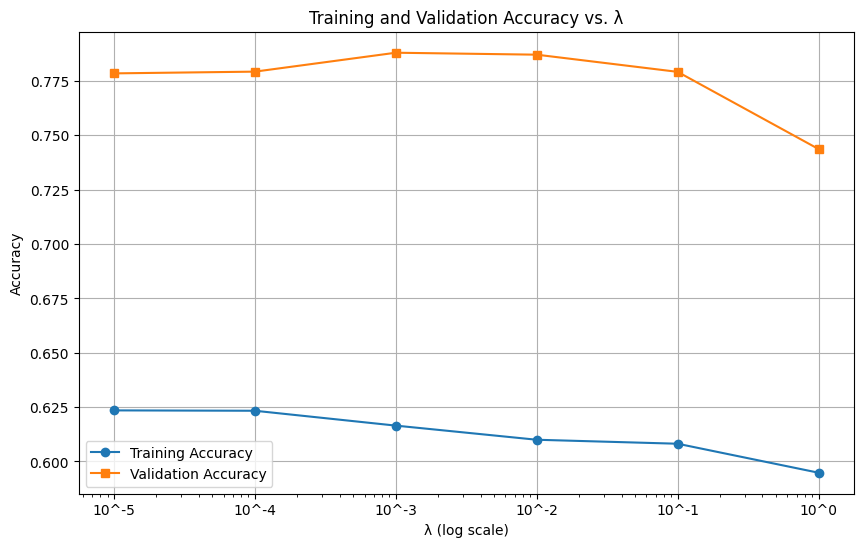

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogx(results_df['λ'], results_df['train_accuracy'], label='Training Accuracy', marker='o')
plt.semilogx(results_df['λ'], results_df['val_accuracy'], label='Validation Accuracy', marker='s')

plt.xlabel('λ (log scale)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. λ')
plt.legend()
plt.grid(True)

# Set x-axis ticks to represent λ as 10^-i
plt.xticks(lambda_values, ['10^{}'.format(int(np.log10(lambda_value))) for lambda_value in lambda_values])

plt.show()

In [ ]:
# Define a range of regularization parameters 𝜆
lambda_values = [10 ** i for i in range(-6, 0)]
print(f'lambda Values : {lambda_values}')

# Initialize a dictionary to store the results
results_list = []
sparsity_results = {}
top_features_lambda = {}
top_features_df = {}# Sort features by magnitude of weight (excluding the bias term)

# Loop over each 𝜆 value
for lambda_reg in lambda_values:

    # Create an instance of the RidgeRegressorwithGD class
    model = LassoLogisticRegressionWithGD(l1_penalty=lambda_reg, learning_rate=2.0)  # Adjust learning rate as needed

    # Fit the model to convergence using your training data
    logistic_loss, learned_weights = model.fit(X_train_noisy, y_train_noisy)


    # Sort feature indices by magnitude of weight (excluding the bias term)
    feature_indices = np.argsort(np.abs(learned_weights[1:]))[::-1][:5]

    # Create a list of top features with their names and weights
    top_features_lambda = [(f'Feature {index}', round(learned_weights[index], 4)) for index in feature_indices]

    # Store the top features in the DataFrame
    top_features_df[lambda_reg] = top_features_lambda

    # Compute sparsity by counting the number of feature weights close to zero
    sparsity = np.sum(np.abs(learned_weights) <= 1e-6)

    # Store the sparsity result for this λ value
    sparsity_results[lambda_reg] = sparsity

    # Evaluate the model on the training data
    train_accuracy = calculate_accuracy(X_train_noisy, y_train_noisy, learned_weights)

    # Evaluate the model on the validation data
    val_accuracy = calculate_accuracy(X_val, y_val, learned_weights)

    # Store the results for this 𝜆 value
    result_dict = {
        'λ': lambda_reg,
        'weights': learned_weights,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'logistic_loss': logistic_loss,
        'top_features': top_features_lambda,
        'sparsity': sparsity
    }
    results_list.append(result_dict)

results_df = pd.DataFrame(results_list)
results_df.set_index('λ', inplace=True)

# Add 'λ' as a regular column
results_df.reset_index(inplace=True)
results_df

lambda Values : [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
Converged after 1177 iterations.
Converged after 2051 iterations.


,λ,weights,train_accuracy,val_accuracy,logistic_loss,top_features,sparsity
0,0.000001,"[-0.6602111522321557, 0.0036982517136516127, -...",0.624167,0.7775,"[0.6931479079787171, 0.6782928186648147, 0.672...","[(Feature 84, 0.444), (Feature 180, -0.8097), ...",47
1,0.000010,"[-0.6908316207763231, 0.0033222269737454933, -...",0.624000,0.7779,"[0.6931544547476622, 0.6783026999910808, 0.672...","[(Feature 84, 0.4108), (Feature 180, -0.7356),...",47
2,0.000100,"[-0.36392608069909843, 0.0006167596357498084, ...",0.621333,0.7817,"[0.6932199224371143, 0.6783992144737416, 0.672...","[(Feature 84, 0.0803), (Feature 38, -0.219), (...",47
3,0.001000,"[-0.20022110678564245, -0.0005482314003152043,...",0.612333,0.7902,"[0.6938745993316341, 0.6793672430003554, 0.674...","[(Feature 3, -0.0003), (Feature 4, -0.5131), (...",47
4,0.010000,"[-0.41454648989215964, -0.010298854755664513, ...",0.504167,0.5071,"[0.7004213682768318, 0.7074360920903269, 0.689...","[(Feature 3, -0.0192), (Feature 4, -0.4403), (...",47
5,0.100000,"[-0.8636906077518658, -0.14598534275299846, -0...",0.504167,0.5066,"[0.7658890577288092, 3.3170581179663436, 1.312...","[(Feature 60, 0.0707), (Feature 35, 0.0062), (...",47


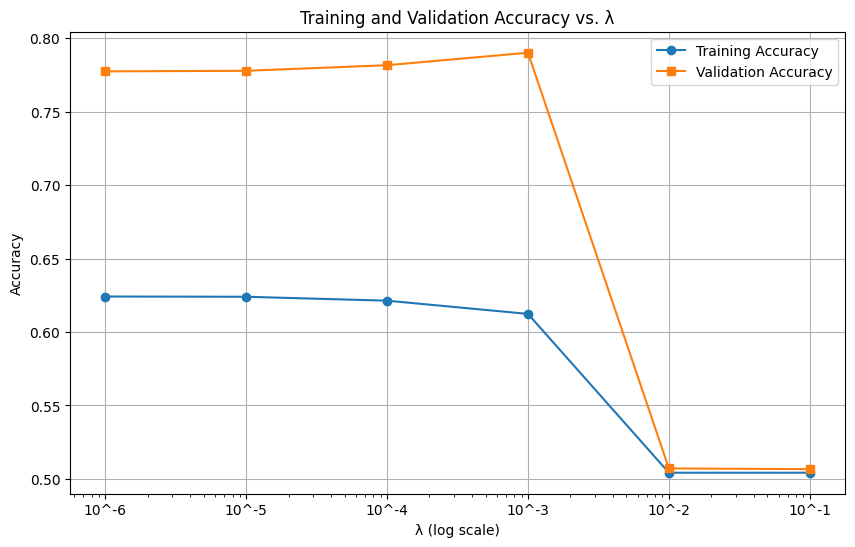

In [ ]:
# Plot the training accuracy and validation accuracy on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.semilogx(results_df['λ'], results_df['train_accuracy'], label='Training Accuracy', marker='o')
plt.semilogx(results_df['λ'], results_df['val_accuracy'], label='Validation Accuracy', marker='s')

plt.xlabel('λ (log scale)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. λ')
plt.legend()
plt.grid(True)

# Set x-axis ticks to represent λ as 10^-i
plt.xticks(lambda_values, ['10^{}'.format(int(np.log10(lambda_value))) for lambda_value in lambda_values])

plt.show()

**Question**
Your experiments should reveal that when trained with the noisy data, both L1 and L2 regulated logistic regression models would have substantially reduced training accuracies, but the validation accuracies will only suffer a mild reduction.  

Here I provide two possible explanations for this phenonmenon:
1. This is due to the use of regularization, which reduces the model's ability to overfit to the noise.
2. This is due to the similicity of the model, which just could not overfit to the noise very well.

For this case, what do you think is the main cause for the observe phenomenon? Why?

Please design another experiment that will allow you to figure out which of the two possibilities plays a more critical role in the observed phenomenon. You do not have to run this experiment, but need to explain the experiment and why it would help.


**Answer:**

**(1)** *I guess the main cause for the observed phenomenon is the use of regularization. Regularization keeps the weights down which helps the model to generalize information from the training data rather than overfitting to it. Unreasonable training data (due to the added random noise) is probably not generalizable, thus its effect on the validation error is small, whereas the models performance on the noisy training data is bad.*

**(2)** *To figure out whether the phenomenon is caused by the the use of regularization one could just perform another experiment where one time the L1/L2 regularization part is omitted when performing gradient descent and the other time a more complex model is beeing used. By comparing the validation accuracies for each case (e.g. plotting them in the same figure) one can find out which of the two given explanations is the main cause for the observed phenomenon.*